# Dog Breed Classification using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

This project we will train a model (using ResNet50 and then hyperparameter tuning) and deploy the model to a Sagemaker Endpoint. To test the deployment, we also will query the deployed model with a sample image and get a prediction.



In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

     |████████████████████████████████| 270 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 7.9 MB/s  eta 0:00:01


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

In [4]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()

## Dataset
We are using the dog breed dataset. The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [6]:
input_path = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix='dogImages')

print(f'S3uri: {input_path}')

S3uri: s3://sagemaker-us-east-1-787668679680/dogImages


In [6]:
input_path = 's3://sagemaker-us-east-1-787668679680/dogImages'

## Hyperparameter Tuning

- learning rate - 0.0001 to 0.1
- eps - 1e-9 to 1e-8
- batch size - 64, 128 and 256

In [7]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "batch_size": CategoricalParameter([64, 128, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [9]:
tuner.fit({"training": input_path}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................................!


In [10]:
#Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-09-21 23:29:38 Starting - Found matching resource for reuse
2022-09-21 23:29:38 Downloading - Downloading input data
2022-09-21 23:29:38 Training - Training image download completed. Training in progress.
2022-09-21 23:29:38 Uploading - Uploading generated training model
2022-09-21 23:29:38 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'eps': '5.498956977166984e-09',
 'lr': '0.00013504371223444837',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-09-21-23-10-34-106"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-787668679680/pytorch-training-2022-09-21-23-10-34-106/source/sourcedir.tar.gz"'}

In [11]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],
                     'eps': best_estimator.hyperparameters()['eps']}

In [12]:
best_hyperparameters

{'batch_size': 128,
 'lr': '0.00013504371223444837',
 'eps': '5.498956977166984e-09'}

## Model Profiling and Debugging

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [13]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    rule_configs,
    ProfilerConfig,
    FrameworkProfile,
    CollectionConfig,
    DebuggerHookConfig)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig(collection_configs=collection_configs)

In [14]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dog-classification",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=best_hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)

estimator.fit({'train' : input_path },wait=True)

2022-09-21 23:31:39 Starting - Starting the training job...
2022-09-21 23:32:05 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-09-21 23:33:07 Downloading - Downloading input data...............
2022-09-21 23:35:41 Training - Downloading the training image...............
2022-09-21 23:38:07 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-21 23:37:52,708 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-21 23:37:52,739 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-21 23:37:52,747 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-21 23:37:53,365 sagemaker-training-toolkit I

In [15]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [16]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-09-21 23:44:35.376 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:275 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-09-21 23:44:35.391 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:275 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-787668679680/dog-classification-2022-09-21-23-31-38-925/debug-output


In [17]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-09-21 23:44:36.500 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:275 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-09-21 23:44:37.522 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:275 INFO trial.py:210] Loaded all steps
11
14


In [18]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight']

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


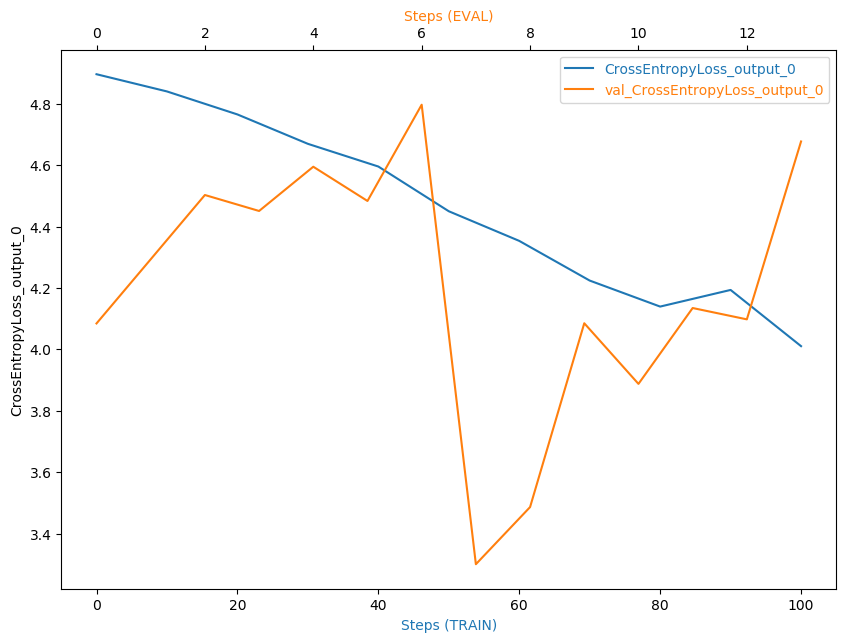

In [20]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

- Seems to have some overfitting. We could try different neural network architecture or use some regularization like dropout.

In [21]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [22]:
! aws s3 ls {rule_output_path} --recursive

2022-09-21 23:44:04     404392 dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-09-21 23:44:03     258128 dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-09-21 23:43:58        192 dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-09-21 23:43:58      19566 dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-09-21 23:43:58       1867 dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-09-21 23:43:58        325 dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-09-21 23:43:58       4696 dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-outp

In [23]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-787668679680/dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-787668679680/dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-787668679680/dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-787668679680/dog-classification-2022-09-21-23-31-38-925/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-787668679680/dog-classification-2022-09-21-23-3

In [24]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [25]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [26]:
import shutil
shutil.make_archive("./profiler_report_file", "zip", "ProfilerReport")

'/root/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_report_file.zip'

## Model Deploying

In [5]:
from sagemaker.serializers import IdentitySerializer
from IPython.display import display, Image
import base64

image = './dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg'
with open(image, "rb") as f:
    payload = f.read()

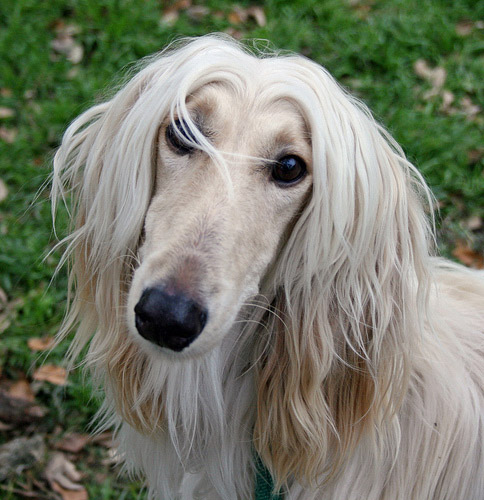

In [6]:
from PIL import Image
import io
with open(image, "rb") as f:
    payload = f.read()
    display(Image.open(io.BytesIO(payload)))

In [12]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

model = "s3://sagemaker-us-east-1-787668679680/dog-classification-2022-09-21-23-31-38-925/output/model.tar.gz"
        
pytorch_model = PyTorchModel(model_data = model,
                             role = role,
                             entry_point= "endpoint.py",
                             py_version = "py36",
                             framework_version = "1.6")

predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.t2.medium")

----------!

In [13]:
predictor.serializer = IdentitySerializer("image/png")

In [25]:
response = predictor.predict(payload)

In [15]:
response

array([[1.35431159e-02, 2.92765760e+00, 1.56564713e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.76777494e-01,
        0.00000000e+00, 1.31383383e+00, 1.38524401e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.08091688e+00, 3.28036726e-01,
        1.17989671e+00, 0.00000000e+00, 7.75229990e-01, 3.90029103e-01,
        8.26025605e-01, 9.59758461e-02, 1.24985468e+00, 1.50379110e-02,
        0.00000000e+00, 7.99861103e-02, 2.21695447e+00, 2.19770521e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.51314306e+00,
        0.00000000e+00, 0.00000000e+00, 5.18115699e-01, 0.00000000e+00,
        0.00000000e+00, 1.48673728e-01, 7.20440447e-02, 0.00000000e+00,
        3.53005677e-01, 1.33502400e+00, 0.00000000e+00, 3.17142427e-01,
        8.63011181e-01, 0.00000000e+00, 0.00000000e+00, 1.11385189e-01,
        0.00000000e+00, 1.31512821e+00, 0.00000000e+00, 4.152560

In [17]:
import numpy as np

In [20]:
np.argmax(response)

1

In [26]:
predictor.delete_endpoint()